In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [50]:
# Initialize weights
def initialize_weights(layer_dimensions):
    np.random.seed(42) # For reproducibility
    parameters = {}
    L = len(layer_dimensions) - 1 # Number of layers excluding input layer
    for l in range(1, L + 1):
        # The initialization for weights
        parameters[f"W{l}"] = np.random.randn(
            layer_dimensions[l], layer_dimensions[l - 1]
            ) * np.sqrt(2 / layer_dimensions[l - 1])

        # Initializing biases to zeros
        parameters[f"b{l}"] = np.zeros((layer_dimensions[l], 1))
    return parameters

In [51]:
# Activation functions
elu_alpha = 1
def elu(x):
    return np.where(x > 0, x, elu_alpha * (np.exp(x) - 1))

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis = 0, keepdims = True)


In [52]:
# cross-entropy Cost function

def cost(y_hat, y):
    assert(y.shape[0] == y_hat.shape[0])
    assert(y.shape[1] == y_hat.shape[1])
    assert(y.shape[1] == 1)

    m = y.shape[1]
    return -np.sum(y * np.log(y_hat)) / m

# Test
y_temp = np.array([[1], [0], [0]])
y_hat_temp = np.array([[0.1], [0.1], [0.8]])
assert(cost(y_hat_temp, y_temp) > 1)

In [53]:
# Forward propagation functions

def linear_and_activation_forward(prev_A, W, b, activation_function):
    # Assert part (for debugging)
    assert(prev_A.shape[1] == 1)
    assert(W.shape[1] == prev_A.shape[0])
    assert(b.shape[1] == 1)
    assert(W.shape[0] == b.shape[0])

    # Linear part forward
    Z = W @ prev_A + b

    # Activation part forward
    if activation_function == 'elu':
        A = elu(Z)
    elif activation_function == 'softmax':
        A = softmax(Z)
    else:
        assert(false)
    
    cache = ((prev_A, W, b), Z)
    return A, cache

def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A, cache = linear_and_activation_forward(A_prev, W, b, 'elu')
        caches.append(cache)
    
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    A, cache = linear_and_activation_forward(A, W, b, 'softmax')
    caches.append(cache)

    return A, caches
    

In [72]:
# Backward propagation functions

def linear_and_activation_backward(dA, cache, is_last_layer):
    # Extract useful caches
    linear_cache, activation_cache = cache
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dZ = np.array(dA, copy = True)

    # Activation part backward
    if not is_last_layer:
        dZ[activation_cache <= 0] = dA[activation_cache <= 0] * (elu_alpha * np.exp(activation_cache[activation_cache <= 0]))

    # Linear part backward
    dW = dZ @ A_prev.T / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = W.T @ dZ

    return dA_prev, dW, db

def backward_propagation(Y, Y_hat, caches):
    grads = {}
    L = len(caches)
    m = Y_hat.shape[1]

    assert(Y.shape == Y_hat.shape)

    dA = Y - Y_hat
    
    dA, dW, db = linear_and_activation_backward(dA, caches[L - 1], True)
    grads[f"dA{L - 1}"] = dA
    grads[f"dW{L}"] = dW
    grads[f"db{L}"] = db
    
    for l in np.arange(L - 2, -1, -1):
        dA, dW, db = linear_and_activation_backward(dA, caches[l], False)
        grads[f"dA{l}"] = dA
        grads[f"dW{l + 1}"] = dW
        grads[f"db{l + 1}"] = db

    return grads

In [73]:
# Update parameters

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate * grads[f"db{l}"]

In [74]:
# Part (i)

hl_count = 5
n_x = 5
n_h = 10 
n_y = 3

layer_dimensions = [n_x] + [n_h] * hl_count + [n_y]
X = np.array([[1], [2], [3], [4], [5]])

parameters = initialize_weights(layer_dimensions)

output, caches = forward_propagation(X, parameters)
print("Output of feed forward is: \n", output)

Output of feed forward is: 
 [[0.01158557]
 [0.40535973]
 [0.5830547 ]]


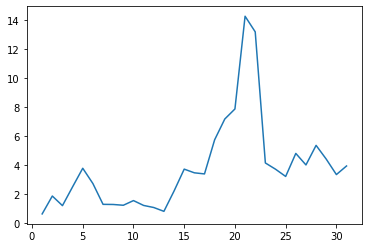

In [75]:
# Part (ii)

# Initialize
hl_count = 30
n_x = 5
n_h = 10 
n_y = 3

layer_dimensions = [n_x] + hl_count * [n_h] + [n_y]
X = np.array([[1], [2], [3], [4], [5]])
Y = np.array([[1], [0], [0]])

# Run forward
parameters = initialize_weights(layer_dimensions)
y_hat, caches = forward_propagation(X, parameters)

# Run backward
grads = backward_propagation(Y, y_hat, caches)

# Plot norm of derivitives
L = len(grads) // 3
xpoints = []
ypoints = []
for l in range(1, L + 1):
    xpoints.append(l)
    ypoints.append(np.linalg.norm(grads[f"dW{l}"]))

plt.plot(xpoints, ypoints)
plt.show()

## Part (ii)

### Explanation: 

In [76]:
# Part (iii)

# Load the CSV file
data = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv', )

# Extract labels and features
features = data.drop('Diabetes_binary', axis = 1)
labels = data['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)
X_train = X_train.T
X_test = X_test.T

# SGD
print(type(X_train))
print(X_train.shape)
print(y_train.shape)
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
(21, 202944)
(202944,)
<class 'pandas.core.series.Series'>


In [70]:
# Initialization
hl_count = 5
n_x = 5
n_h = 10 
n_y = 3

epoch_number = 200
batch_size = 100
learning_rate = 0.5
momentum_v = 0.9
features_count = X_train.shape[1]

for i in range(epoch_number):
    l = i * 100
    r = min(l + batch_size, features_count)
    batch_features = X_train[:, l : r]
    batch_answers = y_train[l, r]
    print(batch_features)
    print(batch_features.size)
    print(batch_answers)
    print(batch_answers.size)
    

TypeError: '(slice(None, None, None), slice(0, 100, None))' is an invalid key